# Import Library

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras import models, optimizers, losses, metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import os
import shutil
import tensorflow as tf
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


# Creating Dataframe From Dataset On Google Drive

In [ ]:
direct = {
    'training': '../content/drive/My Drive/Dataset/chest_xray/train/',
    'validation': '../content/drive/My Drive/Dataset/chest_xray/val/',
    'test': '../content/drive/My Drive/Dataset/chest_xray/test/'
}
labels = {0: 'NORMAL', 1: 'PNEUMONIA'}
citra_df = pd.DataFrame()
for label_numeric, label_words in labels.items():
    for split, path in direct.items():
        combined_path = os.path.join(path, label_words.upper())
        files = os.listdir(combined_path)
        for i, file in enumerate(files):
            files[i] = os.path.join(combined_path, file)
        tmp = pd.DataFrame()
        tmp['path_citra'] = files
        tmp['class'] = label_numeric
        citra_df = citra_df.append(tmp)
citra_df = citra_df.sample(frac=1).reset_index(drop=True) # Shuffle citra_df
citra_df

,path_citra,class
0,../content/drive/My Drive/Dataset/chest_xray/t...,1
1,../content/drive/My Drive/Dataset/chest_xray/t...,1
2,../content/drive/My Drive/Dataset/chest_xray/t...,1
3,../content/drive/My Drive/Dataset/chest_xray/t...,1
4,../content/drive/My Drive/Dataset/chest_xray/t...,1
...,...,...
5851,../content/drive/My Drive/Dataset/chest_xray/t...,1
5852,../content/drive/My Drive/Dataset/chest_xray/t...,1
5853,../content/drive/My Drive/Dataset/chest_xray/t...,1
5854,../content/drive/My Drive/Dataset/chest_xray/t...,0


# Visulaiztion Sample Images and Distrubition Data

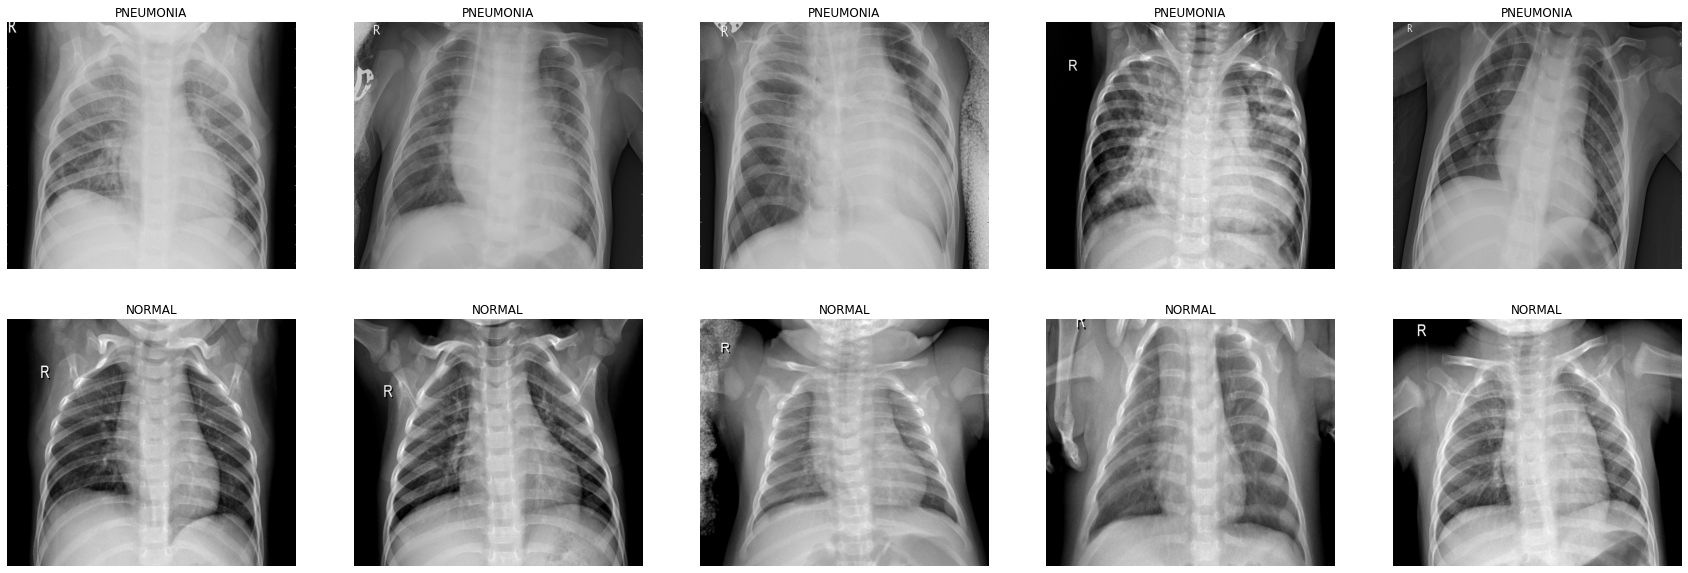

In [ ]:
sample_citra_pneumonia = citra_df[citra_df['class']==1]['path_citra'].iloc[:5]
sample_citra_normal = citra_df[citra_df['class']==0]['path_citra'].iloc[:5]

samples = sample_citra_pneumonia.append(sample_citra_normal).to_list()

_, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("PNEUMONIA")
    else:
        ax[i//5, i%5].set_title("NORMAL")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

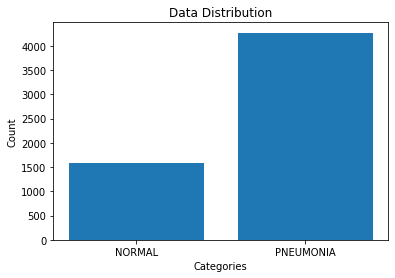

In [ ]:
# Plot Image Distribution
class_citra = ['NORMAL', 'PNEUMONIA']
freq_data = list(citra_df['class'].value_counts())[::-1]
plt.bar(class_citra, freq_data)
plt.xlabel("Categories")
plt.ylabel("Count")
plt.title(f'Data Distribution')
plt.show()

# Creating Data Training (80%), Testing (10%), Validation (10%)

In [ ]:
train_split = citra_df.iloc[:round(len(citra_df) * 0.8)]
val_split = citra_df.iloc[round(len(citra_df) * 0.8): round(len(citra_df) * 0.9)]
test_split = citra_df.iloc[round(len(citra_df) * 0.9):]

directories = {'train': train_split, 'validation': val_split, 'test': test_split}

for directory, split in directories.items():
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.mkdir(directory)
    normal_path = os.path.join(directory, 'normal')
    pneumonia_path = os.path.join(directory, 'pneumonia')
    os.mkdir(normal_path)
    os.mkdir(pneumonia_path)
    for index, entry in split.iterrows():
        file = os.path.basename(entry['path_citra'])
        src = entry['path_citra']
        dst = os.path.join(normal_path, file) if entry['class'] == 0 else os.path.join(pneumonia_path, file)
        shutil.copyfile(src, dst)

# Creating Model CNN

In [ ]:
METRICS = [
    metrics.BinaryAccuracy(name='accuracy'),
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall'),
    metrics.AUC(name='auc'),
    metrics.AUC(name='prc', curve='PR')
]

model = Sequential([
    layers.Conv2D(16, (3, 3), activation = layers.ReLU(), padding = 'same', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(32, (3, 3), activation = layers.ReLU(), padding = 'same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3, 3), activation = layers.ReLU(), padding = 'same'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(128, activation=layers.ReLU()),
    layers.Dense(1, activation = 'sigmoid')
])

model.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=METRICS
)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 32, 32, 64)      

In [ ]:
! pip install visualkeras

     |████████████████████████████████| 992 kB 31.9 MB/s 


# Visualiztion Of Model 

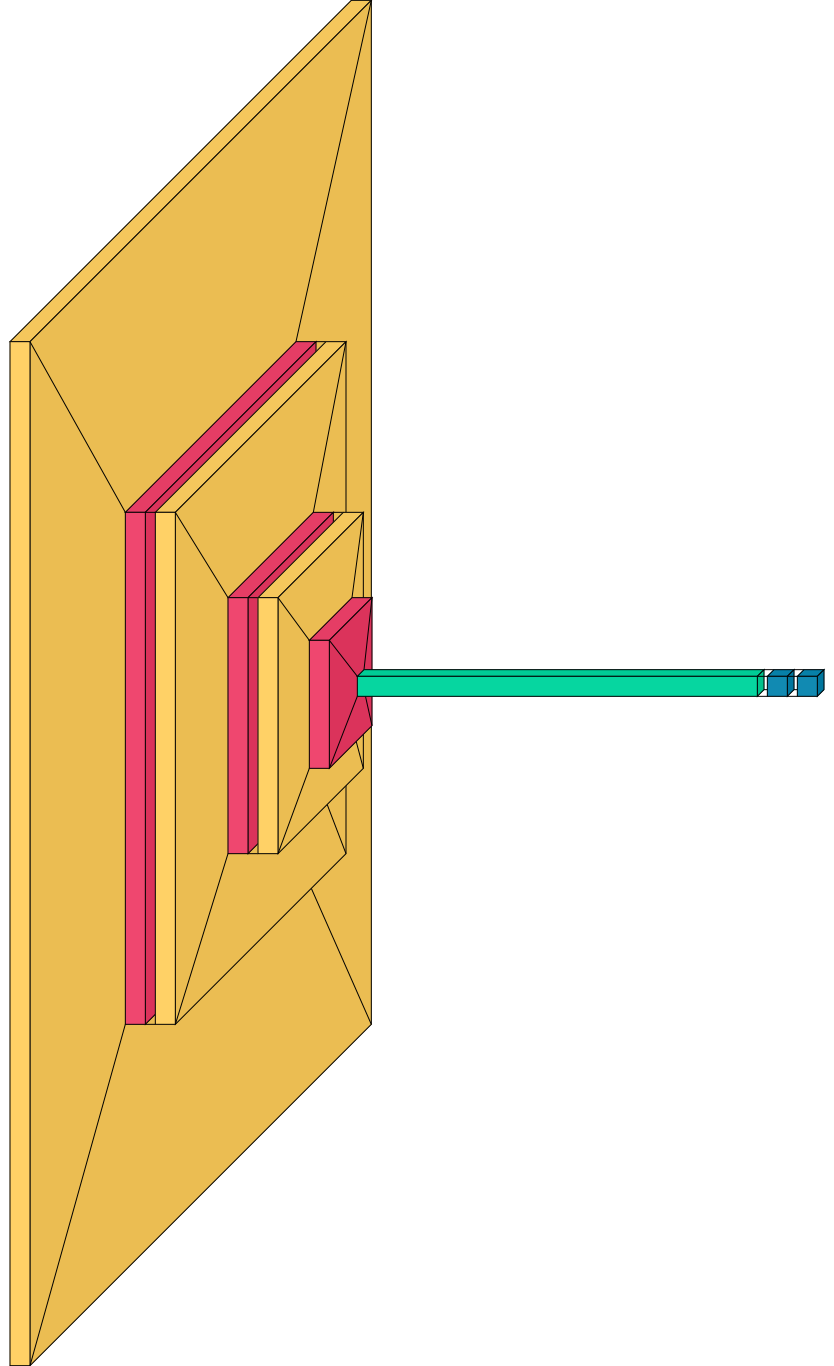

In [ ]:
import visualkeras
visualkeras.layered_view(model).show()
visualkeras.layered_view(model, to_file='Model_PNEUMONIA_Endow.png').show()

visualkeras.layered_view(model)

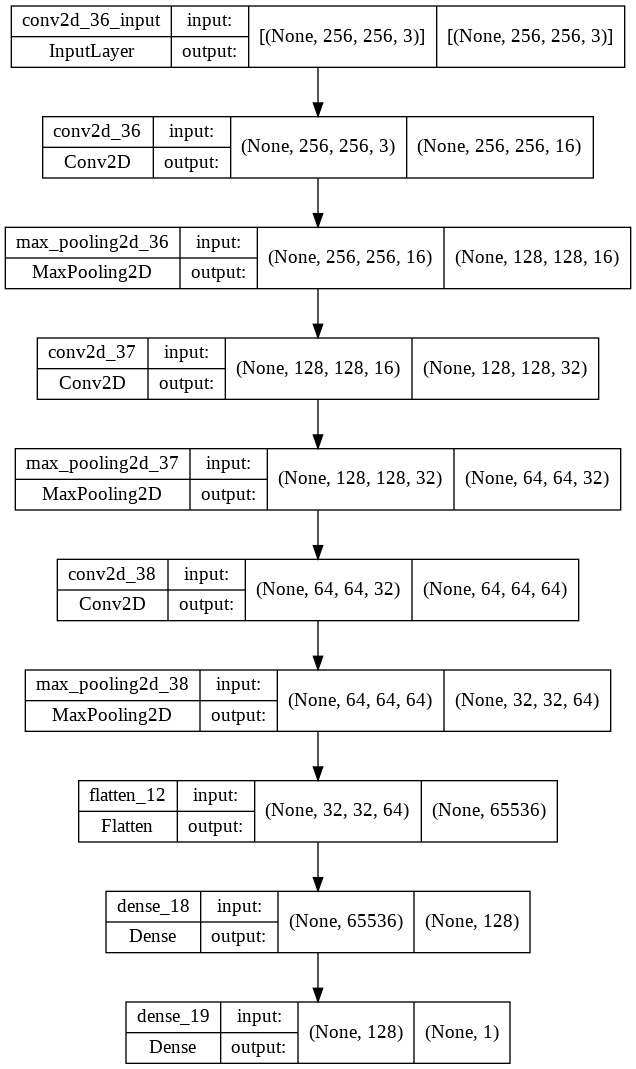

In [ ]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(model, to_file='Model_PNEUMONIA_CNN_Endow.png', show_shapes=True)

# Image Augmentation and Fitting Model

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)
validation_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    'train/',
    target_size=(256, 256),
    batch_size=32,
    color_mode='rgb',
    class_mode='binary'
)
validation_generator = validation_datagen.flow_from_directory(
    'validation/',
    target_size=(256, 256),
    batch_size=32,
    color_mode='rgb',
    class_mode='binary'
)
test_generator = test_datagen.flow_from_directory(
    'test/',
    target_size=(256, 256),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
)
model.save('Model_PNEUMONIA_Endow.hdf5')

Found 4685 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 586 images belonging to 2 classes.
Epoch 1/20
147/147 [==============================] - 399s 3s/step - loss: 0.4224 - accuracy: 0.8209 - precision: 0.8457 - recall: 0.9215 - auc: 0.8669 - prc: 0.9354 - val_loss: 0.2270 - val_accuracy: 0.9197 - val_precision: 0.9378 - val_recall: 0.9532 - val_auc: 0.9657 - val_prc: 0.9865
Epoch 2/20
147/147 [==============================] - 383s 3s/step - loss: 0.2875 - accuracy: 0.8779 - precision: 0.9059 - recall: 0.9283 - auc: 0.9355 - prc: 0.9728 - val_loss: 0.1978 - val_accuracy: 0.9162 - val_precision: 0.9335 - val_recall: 0.9532 - val_auc: 0.9692 - val_prc: 0.9883
Epoch 3/20
147/147 [==============================] - 383s 3s/step - loss: 0.2478 - accuracy: 0.8982 - precision: 0.9233 - recall: 0.9377 - auc: 0.9516 - prc: 0.9796 - val_loss: 0.2049 - val_accuracy: 0.9282 - val_precision: 0.9385 - val_recall: 0.9649 - val_auc: 0.9689 - val_prc: 0.9877
Epoch 4/2

## 2.3 Evaluating Model Results

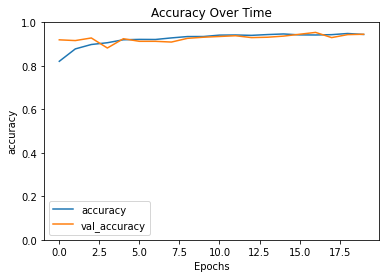

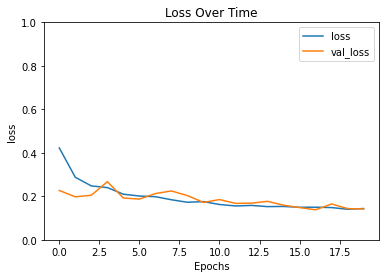

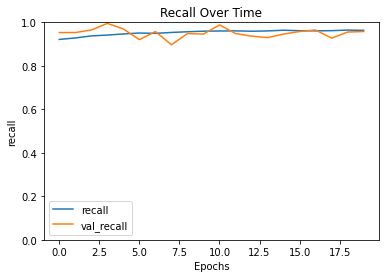

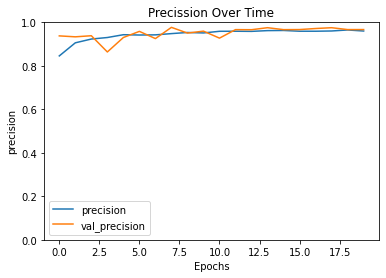

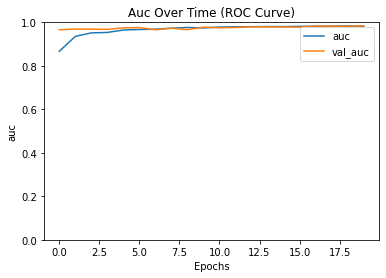

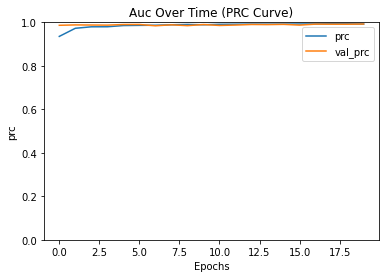

In [ ]:
analisis_train = ['accuracy', 'loss', 'recall', 'precision', 'auc', 'prc']
analisis_val = ['val_accuracy', 'val_loss', 'val_recall','val_precision', 'val_auc', 'val_prc' ]
notes = ['Accuracy Over Time', 'Loss Over Time', 'Recall Over Time', 'Precission Over Time', 'Auc Over Time (ROC Curve)', 'Auc Over Time (PRC Curve)']

for analize in range(0, len(analisis_train)):
  plt.plot(history.history[analisis_train[analize]], label=analisis_train[analize])
  plt.plot(history.history[analisis_val[analize]], label = analisis_val[analize])
  plt.xlabel('Epochs')
  plt.ylabel(analisis_train[analize])
  plt.ylim(0, 1)
  plt.title(notes[analize])
  plt.legend()
  plt.show()

# Visualization Confusion Matrix

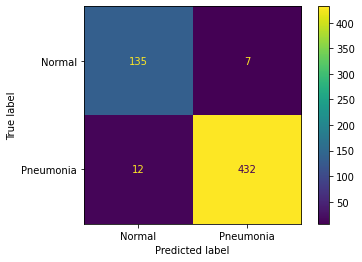

In [ ]:
y_pred = np.round(model.predict(test_generator)).flatten()
y_true = test_generator.classes
display(ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=['Normal', 'Pneumonia']).plot())

In [ ]:
# Evaluating model on the test set
model.evaluate(test_generator)

19/19 [==============================] - 16s 777ms/step - loss: 0.1067 - accuracy: 0.9676 - precision: 0.9841 - recall: 0.9730 - auc: 0.9873 - prc: 0.9944


[0.1066526398062706,
 0.967576801776886,
 0.984054684638977,
 0.9729729890823364,
 0.9872636198997498,
 0.9943814277648926]

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       142
           1       0.98      0.97      0.98       444

    accuracy                           0.97       586
   macro avg       0.95      0.96      0.96       586
weighted avg       0.97      0.97      0.97       586

